In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    # PyTorchのテンソルの場合、detachしてからnumpyに変換
    img = img.cpu().detach().numpy()
    # 画像のサイズ設定とプロット
    plt.figure(figsize=(5, 15))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')  # 軸を非表示
    plt.show()


In [19]:
device = torch.device('cuda')
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])
imagenet_data = dsets.ImageFolder(root='/data01/imagenet/train_256', transform=transform)
data_loader = Data.DataLoader(imagenet_data, batch_size=1, shuffle=False)


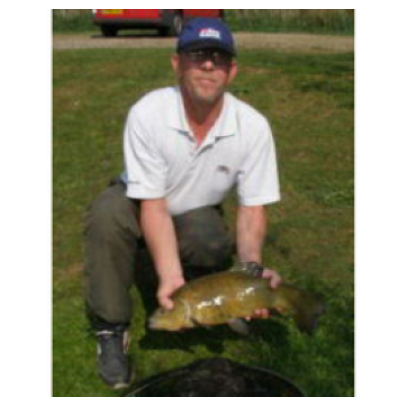

In [27]:
data_loader = iter(data_loader)
images, labels = next(data_loader)
imshow(torchvision.utils.make_grid(images, normalize=True))
data_loader = Data.DataLoader(imagenet_data, batch_size=1, shuffle=False)


In [57]:
class LinfPGDAttack(object):
    def __init__(self, model, criterion, epsilon=0.0314, k=7, alpha=0.00784):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.k = k
        self.alpha = alpha

    def perturb(self, x_natural, y):
        x_natural = x_natural.clone().detach()
        x = x_natural + torch.zeros_like(x_natural).uniform_(-self.epsilon, self.epsilon)
        for _ in range(self.k):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = self.criterion(logits, y)
            grad = torch.autograd.grad(loss, [x])[0]
            x = x.detach() + self.alpha * torch.sign(grad.detach())
            x = torch.min(torch.max(x, x_natural - self.epsilon), x_natural + self.epsilon)
            x = torch.clamp(x, 0, 1)
            
        return x

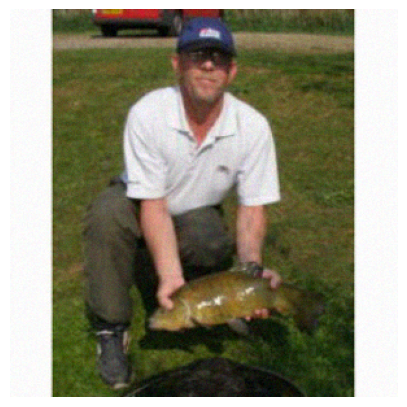

In [58]:
from src.model import CNNModel
model = CNNModel('ResNet18', 1000, True).to(device)
criterion = nn.CrossEntropyLoss()
model.eval()
adversary = LinfPGDAttack(model, criterion)
data_loader = Data.DataLoader(imagenet_data, batch_size=1, shuffle=False)

for (inputs, targets) in data_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    adv_inputs = adversary.perturb(inputs, targets)
    imshow(torchvision.utils.make_grid(adv_inputs, normalize=True))
    break

In [7]:
from PIL import Image
import numpy as np

img = Image.open('/home/ueno/dataset/CIFAR-10-C-ImageFolder/brightness/0/3.png')
img_np = np.array(img)
print("Shape:", img_np.shape)  # 例： (高さ, 幅, 3) ならRGBのはず
print("Image mode:", img.mode)  # "RGB" であるべき

for i, channel in enumerate(['R', 'G', 'B']):
    channel_data = img_np[:, :, i]
    print(f"{channel} channel -> min: {channel_data.min()}, max: {channel_data.max()}, "
          f"mean: {channel_data.mean():.2f}, std: {channel_data.std():.2f}")


Shape: (32, 32, 3)
Image mode: RGB
R channel -> min: 49, max: 227, mean: 163.25, std: 52.99
G channel -> min: 43, max: 231, mean: 161.60, std: 53.29
B channel -> min: 51, max: 246, mean: 173.31, std: 62.26
